# Customizing the queries

As some of the examples in the basic **Pyrosm** tutorial shows, it is possible to customize the parsing calls using a specific `custom_filter` parameter. This parameter is currently available for all methods except `get_network()`. 
The `custom_filter` can be highly useful if you want to parse only certain type of OpenStreetMap elements from the PBF, such as "residential" buildings or specific shops such as "book" -shops. 

In addition, Pyrosm allows the user to customize which attributes are parsed from the OSM elements into GeoDataFrame columns when parsing the data using the `extra_tags` -parameter. There is a specific set of default attributes that are always parsed from the OSM elements, but as OpenStreetMap is highly flexible in terms of what information can be associated with the data, this parameter makes it easy to parse some of the more "exotic" tags from the OSM. 

**Contents:**

 - [How to modify the parsing process with customized filters?](#Constructing-a-custom-filter)
 - [Advanced filtering](#Advanced-filtering)


## Constructing a custom filter

Before diving into documentation about how to construct a custom filter, it is good to understand a bit how OpenStreetMap data is constructed. OpenStreetMap represents: 

>_"physical features on the ground (e.g., roads or buildings) using tags attached to its basic data structures (its nodes, ways, and relations). Each tag describes a geographic attribute of the feature being shown by that specific node, way or relation"_ ([OSM Wiki, 2020](https://wiki.openstreetmap.org/wiki/Map_Features)). 

Pyrosm is in fact going through these tags behind the scenes and filters OSM data elements according specific predefined criteria that makes it possible to parse e.g. buildings or roads from the data. `custom_filter` can be used to modify this process. 

There are certain rules that comes to constructing the `custom_filter`. The filter should always be a **Python dictionary** where the `key` should be a string and the `value` should be a list of OSM tag-values matching the criteria defined by the user. The `key` should correspond to the key in OpenStreetMap tags (e.g. "building") and the value-list should correspond the OSM values that are associated with the keys. You can see a long list of possible OSM keys and associated values from [OSM Map Features](https://wiki.openstreetmap.org/wiki/Map_Features) wiki page.

As an example, a filter can look something like the one below which would parse all residential and retail buildings from the data:

  - `{"building": ["residential", "retail"]}`
  
This `custom_filter` can be used with `get_buildings()` or `get_osm_by_custom_criteria()` -function. With any other function, this filter does not have any effect on the results, as `"building"` tag is only associated with physical features representing buildings. Hence, if you would use this filter e.g. when parsing roads with `get_network()`, it wouldn't do anything because none of the roads contain information about buildings (*shouldn't at least*).   

Let's test:

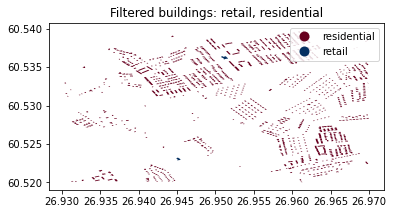

In [1]:
from pyrosm import OSM, get_path
# Get test data 
fp = get_path("test_pbf")

# Initialize the reader
osm = OSM(fp)

# Read buildings with custom filter
my_filter = {"building": ["residential", "retail"]}
buildings = osm.get_buildings(custom_filter=my_filter)

# Plot
title = "Filtered buildings: " + ", ".join(buildings["building"].unique())
ax = buildings.plot(column="building", cmap="RdBu", legend=True)
ax.set_title(title);

As we can see, as a result the data now only includes buildings that have `residential` or `retail` as a value for the key "building". 

### Different kind of filters  

In some cases, such as when parsing Points of Interest (POI) from the PBF, it might be useful to e.g. parse all OSM features that are [shops](https://wiki.openstreetmap.org/wiki/Key:shop). If you do **not** want to specify *what kind* shops to parse from the PBF (i.e. **include all**), it is possible to add `True` as a value in the `custom_filter`, such as in the case `A` below. 

Example filters: 

 - A: `custom_filter={"shop": True}`
 - B: `custom_filter={"shop": True, "tourism": True, "amenity": True, "leisure": True}`
 - C: `custom_filter={"shop": ["alcohol"], "tourism": True, "amenity": ["restaurant", "bar"], "leisure": ["dance"]}`
 
All of the above filters produce slightly different results. The filter `A` would return all shops, `B` would return a broad selection of POIs including all data that relates to shops, tourism, amenities or leisure. 
Filter `C` is very specific filter that might be used by someone in a party mood and being interested in knowing the shops selling alcohol, restaurants and bars, everything related to tourism and leisure activities related to dancing.    

Let's test:

#### Filter A

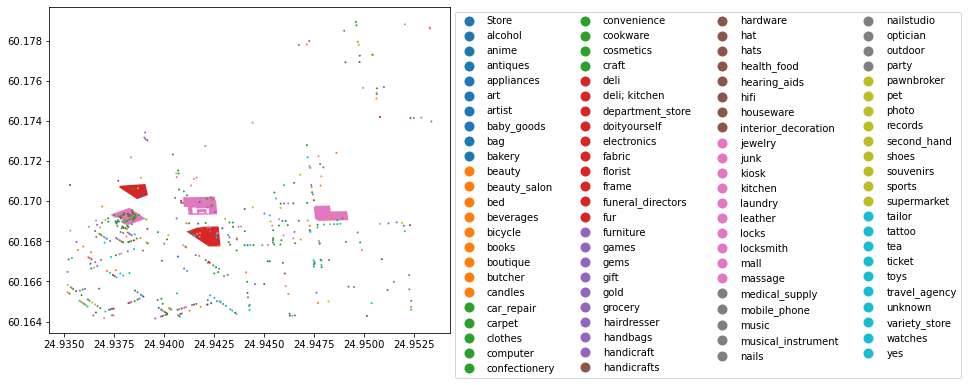

In [2]:
from pyrosm import OSM, get_path
# Get test data 
fp = get_path("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)

# Read POIs with custom filter A
my_filter = {"shop": True}
            
pois = osm.get_pois(custom_filter=my_filter)

# Plot
ax = pois.plot(column="shop", legend=True, markersize=1, figsize=(14,6), legend_kwds=dict(loc='upper left', ncol=4, bbox_to_anchor=(1, 1)))

#### Filter B

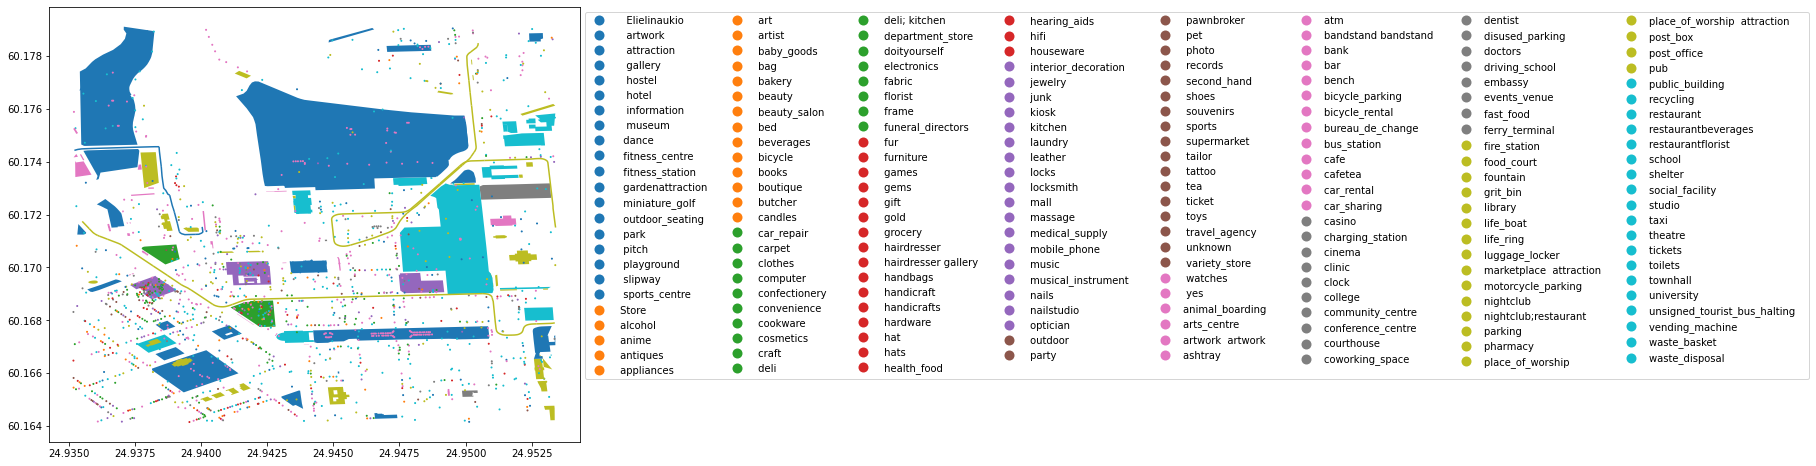

In [3]:
from pyrosm import OSM, get_path
# Get test data 
fp = get_path("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)

# Read POIs with custom filter B
my_filter={"shop": True, "tourism": True, "amenity": True, "leisure": True}
pois = osm.get_pois(custom_filter=my_filter)

# Merge poi type information into a single column
pois["shop"] = pois["shop"].fillna(' ')
pois["amenity"] = pois["amenity"].fillna(' ')
pois["leisure"] = pois["leisure"].fillna(' ')
pois["tourism"] = pois["tourism"].fillna(' ')
pois["poi_type"] = pois["amenity"] + pois["shop"] + pois["leisure"] + pois["tourism"] 

# Plot
ax = pois.plot(column="poi_type", legend=True, markersize=1, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=8, bbox_to_anchor=(1, 1)))

#### Filter C

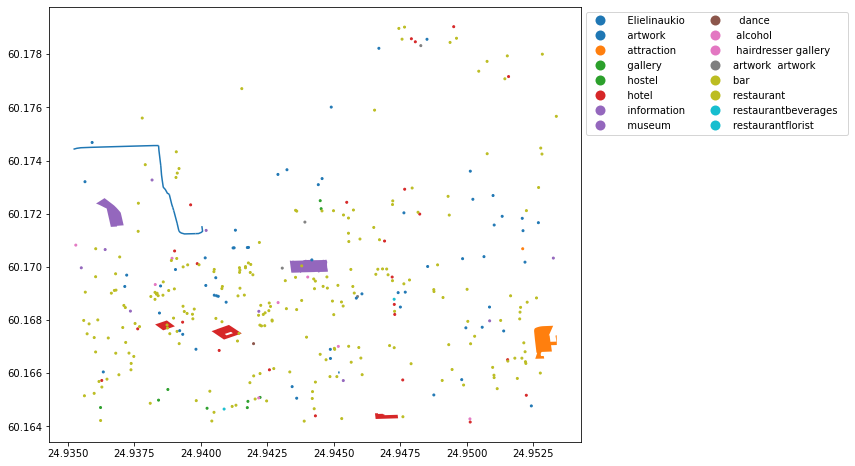

In [4]:
from pyrosm import OSM, get_path
# Get test data 
fp = get_path("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)

# Read POIs with custom filter B
my_filter={"shop": ["alcohol"], "tourism": True, "amenity": ["restaurant", "bar"], "leisure": ["dance"]}
pois = osm.get_pois(custom_filter=my_filter)

# Merge poi type information into a single column
pois["shop"] = pois["shop"].fillna(' ')
pois["amenity"] = pois["amenity"].fillna(' ')
pois["leisure"] = pois["leisure"].fillna(' ')
pois["tourism"] = pois["tourism"].fillna(' ')
pois["poi_type"] = pois["amenity"] + pois["shop"] + pois["leisure"] + pois["tourism"] 

# Plot
ax = pois.plot(column="poi_type", legend=True, markersize=4, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=2, bbox_to_anchor=(1, 1)))

As we can see from these examples. Using the `custom_filter` is an efficient way to customize what data is extracted from the OpenStreetMap data.

## Advanced filtering

If the above methods do not meet your needs pyrosm provides a method `get_data_by_custom_criteria()` to fully customize what kind of data will be parsed from the OSM PBF, and how the filtering is conducted. The method provides possibility to specify what kind of OSM elements are parsed (nodes, ways, relations, or any combination of these) and it also provides possibility to determine whether the specified filter should be used to `"keep`" the data or `"exclude"` the data from OSM.

See further documentation below:

In [5]:
from pyrosm import OSM, get_path
fp = get_path("helsinki_pbf")

# Initialize the reader
osm = OSM(fp)
help(osm.get_data_by_custom_criteria)

Help on method get_data_by_custom_criteria in module pyrosm.pyrosm:

get_data_by_custom_criteria(custom_filter, osm_keys_to_keep=None, filter_type='keep', tags_as_columns=None, keep_nodes=True, keep_ways=True, keep_relations=True, extra_attributes=None) method of pyrosm.pyrosm.OSM instance
    Parse OSM data based on custom criteria.
    
    Parameters
    ----------
    
    custom_filter : dict (required)
        A custom filter to filter only specific POIs from OpenStreetMap.
    
    osm_keys_to_keep : str | list
        A filter to specify which OSM keys should be kept.
    
    filter_type : str
        "keep" | "exclude"
        Whether the filters should be used to keep or exclude the data from OSM.
    
    tags_as_columns : list
        Which tags should be kept as columns in the resulting GeoDataFrame.
    
    keep_nodes : bool
        Whether or not the nodes should be kept in the resulting GeoDataFrame if they are found.
    
    keep_ways : bool
        Whether or not t